<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_CatBoost_StartingPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
import pandas as pd
import numpy as np
import catboost
import shap
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_roc_curve, get_fpr_curve, get_fnr_curve, select_threshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
np.set_printoptions(precision=4)
print("NumPy version:", np.__version__)
print("CatBoost version:", catboost.__version__)

NumPy version: 1.23.5
CatBoost version: 1.2.2


In [ ]:
from catboost.datasets import amazon
train_df, test_df = amazon()
print("train data frame shape: ", train_df.shape)
print("test data frame shape: ", test_df.shape)

train data frame shape:  (32769, 10)
test data frame shape:  (58921, 10)


In [ ]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                58921 non-null  int64
 1   RESOURCE          58921 non-null  int64
 2   MGR_ID            58921 non-null  int64
 3   ROLE_ROLLUP_1     58921 non-null  int64
 4   ROLE_ROLLUP_2     58921 non-null  int64
 5   ROLE_DEPTNAME     58921 non-null  int64
 6   ROLE_TITLE        58921 non-null  int64
 7   ROLE_FAMILY_DESC  58921 non-null  int64
 8   ROLE_FAMILY       58921 non-null  int64
 9   ROLE_CODE         58921 non-null  int64
dtypes: int64(10)
memory usage: 4.5 MB


In [ ]:
for col in train_df.columns:
    print(col, train_df[col].nunique())

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [ ]:
X = train_df.drop(["ACTION"], axis=1)
y = train_df.ACTION

In [ ]:
cat_features = list(range(0, X.shape[1]))
cat_features

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
print("Labels: {}".format(set(y)))
print("Number of zeros and ones are {}, {}, respectively!".format(len(y)-sum(y), sum(y)))

Labels: {0, 1}
Number of zeros and ones are 1897, 30872, respectively!


In [ ]:
clf = CatBoostClassifier(iterations=100)
clf.fit(X, y, cat_features=cat_features, verbose=10)

Learning rate set to 0.377604
0:	learn: 0.4528598	total: 74.5ms	remaining: 7.38s
10:	learn: 0.1744186	total: 183ms	remaining: 1.48s
20:	learn: 0.1676119	total: 325ms	remaining: 1.22s
30:	learn: 0.1652446	total: 448ms	remaining: 998ms
40:	learn: 0.1633644	total: 555ms	remaining: 798ms
50:	learn: 0.1621892	total: 667ms	remaining: 641ms
60:	learn: 0.1609164	total: 772ms	remaining: 494ms
70:	learn: 0.1594572	total: 875ms	remaining: 357ms
80:	learn: 0.1585876	total: 981ms	remaining: 230ms
90:	learn: 0.1573593	total: 1.09s	remaining: 108ms
99:	learn: 0.1566977	total: 1.2s	remaining: 0us


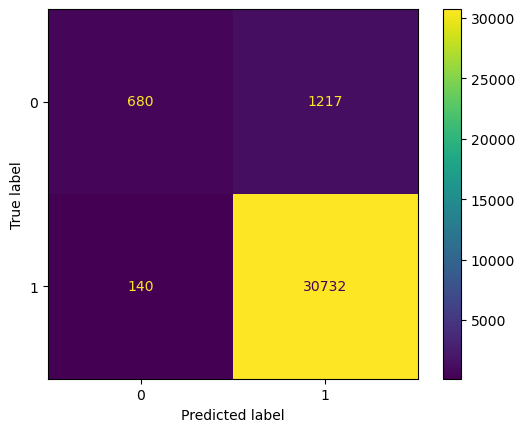

In [ ]:
predictions = np.argmax(clf.predict_proba(X), axis=1)
cm = confusion_matrix(y_true=y, y_pred=predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=0)
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
validation_pool = Pool(data=X_validation, label=y_validation, cat_features=cat_features)
model = CatBoostClassifier(iterations=100, learning_rate=0.1, loss_function="Logloss")
model.fit(train_pool, eval_set=validation_pool, verbose=10)
print("Model is fitted: {}".format(model.is_fitted()))
print("Model parameters: {}".format(model.get_params()))

0:	learn: 0.6189489	test: 0.6187790	best: 0.6187790 (0)	total: 13.7ms	remaining: 1.36s
10:	learn: 0.3023734	test: 0.3000875	best: 0.3000875 (10)	total: 119ms	remaining: 963ms
20:	learn: 0.2224740	test: 0.2182753	best: 0.2182753 (20)	total: 197ms	remaining: 740ms
30:	learn: 0.1915694	test: 0.1843315	best: 0.1843315 (30)	total: 336ms	remaining: 747ms
40:	learn: 0.1810866	test: 0.1723486	best: 0.1723486 (40)	total: 475ms	remaining: 684ms
50:	learn: 0.1766195	test: 0.1650760	best: 0.1650760 (50)	total: 588ms	remaining: 565ms
60:	learn: 0.1743201	test: 0.1620310	best: 0.1620310 (60)	total: 690ms	remaining: 441ms
70:	learn: 0.1727259	test: 0.1604053	best: 0.1604053 (70)	total: 803ms	remaining: 328ms
80:	learn: 0.1717055	test: 0.1592850	best: 0.1592850 (80)	total: 910ms	remaining: 213ms
90:	learn: 0.1709790	test: 0.1587529	best: 0.1587529 (90)	total: 1.01s	remaining: 99.9ms
99:	learn: 0.1704454	test: 0.1585780	best: 0.1584908 (96)	total: 1.09s	remaining: 0us

bestTest = 0.1584908358
bestItera

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=0)
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
validation_pool = Pool(data=X_validation, label=y_validation, cat_features=cat_features)
model = CatBoostClassifier(iterations=100, learning_rate=0.1, custom_loss=["AUC", "Accuracy", "Logloss"],
                           train_dir="catboost_dir")
model.fit(train_pool, eval_set=validation_pool, verbose=10, plot=False)
print("Model is fitted: {}".format(model.is_fitted()))
print("Model parameters: {}".format(model.get_params()))
print("Tree count:" + str(model.tree_count_))
catboost.MetricVisualizer(["catboost_dir"]).start()

0:	learn: 0.6189489	test: 0.6187790	best: 0.6187790 (0)	total: 12ms	remaining: 1.19s
10:	learn: 0.3023734	test: 0.3000875	best: 0.3000875 (10)	total: 100ms	remaining: 809ms
20:	learn: 0.2224740	test: 0.2182753	best: 0.2182753 (20)	total: 179ms	remaining: 675ms
30:	learn: 0.1915694	test: 0.1843315	best: 0.1843315 (30)	total: 270ms	remaining: 600ms
40:	learn: 0.1810866	test: 0.1723486	best: 0.1723486 (40)	total: 362ms	remaining: 521ms
50:	learn: 0.1766195	test: 0.1650760	best: 0.1650760 (50)	total: 452ms	remaining: 434ms
60:	learn: 0.1743201	test: 0.1620310	best: 0.1620310 (60)	total: 556ms	remaining: 355ms
70:	learn: 0.1727259	test: 0.1604053	best: 0.1604053 (70)	total: 673ms	remaining: 275ms
80:	learn: 0.1717055	test: 0.1592850	best: 0.1592850 (80)	total: 776ms	remaining: 182ms
90:	learn: 0.1709790	test: 0.1587529	best: 0.1587529 (90)	total: 876ms	remaining: 86.6ms
99:	learn: 0.1704454	test: 0.1585780	best: 0.1584908 (96)	total: 972ms	remaining: 0us

bestTest = 0.1584908358
bestIterati

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
params = {
    "loss_function": "Logloss",
    "iterations": 80,
    "custom_loss": "AUC",
    "learning_rate": 0.1
}
cv_data = cv(params=params, pool=train_pool, fold_count=5,
             shuffle=True, partition_random_seed=0, plot=True, verbose=20, stratified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.5812867	test: 0.5812871	best: 0.5812871 (0)	total: 24.7ms	remaining: 1.95s
20:	learn: 0.1932578	test: 0.1849005	best: 0.1849005 (20)	total: 400ms	remaining: 1.12s
40:	learn: 0.1760028	test: 0.1652442	best: 0.1652442 (40)	total: 746ms	remaining: 710ms
60:	learn: 0.1709795	test: 0.1622999	best: 0.1622999 (60)	total: 1.1s	remaining: 343ms
79:	learn: 0.1687357	test: 0.1613221	best: 0.1612996 (78)	total: 1.61s	remaining: 0us

bestTest = 0.1612996284
bestIteration = 78

Training on fold [1/5]
0:	learn: 0.5812726	test: 0.5812835	best: 0.5812835 (0)	total: 11.1ms	remaining: 877ms
20:	learn: 0.1924537	test: 0.1863979	best: 0.1863979 (20)	total: 277ms	remaining: 779ms
40:	learn: 0.1761818	test: 0.1680655	best: 0.1680655 (40)	total: 601ms	remaining: 572ms
60:	learn: 0.1710659	test: 0.1634331	best: 0.1634331 (60)	total: 924ms	remaining: 288ms
79:	learn: 0.1682807	test: 0.1617425	best: 0.1617425 (79)	total: 1.28s	remaining: 0us

bestTest = 0.1617424602
bestIterati

In [ ]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.581285,0.000002,0.581281,0.000007,0.496175,0.014042
1,1,0.496233,0.000040,0.496221,0.000035,0.519188,0.016686
2,2,0.430985,0.000034,0.430972,0.000030,0.519188,0.016686
3,3,0.381694,0.000227,0.381684,0.000312,0.532236,0.022482
4,4,0.342926,0.000777,0.342961,0.000705,0.580106,0.031891


In [ ]:
best_value = np.min(cv_data["test-Logloss-mean"])
best_itr = np.argmin(cv_data["test-Logloss-mean"])
print("Best validation logloss: {:.4f}±{:.4f} on step {}".format(best_value, cv_data["test-Logloss-std"][best_itr], best_itr))

Best validation logloss: 0.1623±0.0026 on step 79


In [ ]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.5]
}
clf = CatBoostClassifier(
    iterations=20,
    cat_features=cat_features,
    verbose=20
)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=2)
results = grid_search.fit(X_train, y_train)
results.best_estimator_.get_params()

0:	learn: 0.6854053	total: 5.21ms	remaining: 99ms
19:	learn: 0.5630952	total: 57.4ms	remaining: 0us
0:	learn: 0.6853954	total: 3.95ms	remaining: 75ms
19:	learn: 0.5631574	total: 64.8ms	remaining: 0us
0:	learn: 0.6192124	total: 4.24ms	remaining: 80.5ms
19:	learn: 0.2347140	total: 59.9ms	remaining: 0us
0:	learn: 0.6191226	total: 4.45ms	remaining: 84.5ms
19:	learn: 0.2350162	total: 78.6ms	remaining: 0us
0:	learn: 0.3980546	total: 5.96ms	remaining: 113ms
19:	learn: 0.1824618	total: 108ms	remaining: 0us
0:	learn: 0.3977985	total: 4.59ms	remaining: 87.3ms
19:	learn: 0.1775158	total: 101ms	remaining: 0us
0:	learn: 0.3971379	total: 10.7ms	remaining: 203ms
19:	learn: 0.1717590	total: 169ms	remaining: 0us


{'iterations': 20,
 'learning_rate': 0.5,
 'verbose': 20,
 'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8]}

In [ ]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20,
    eval_metric="AUC"
)
model.fit(train_pool, eval_set=validation_pool, verbose=True, plot=True)
print(model.tree_count_)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5509439	best: 0.5509439 (0)	total: 29.8ms	remaining: 5.93s
1:	test: 0.6760414	best: 0.6760414 (1)	total: 60.3ms	remaining: 5.97s
2:	test: 0.8346361	best: 0.8346361 (2)	total: 89.8ms	remaining: 5.9s
3:	test: 0.8450107	best: 0.8450107 (3)	total: 118ms	remaining: 5.77s
4:	test: 0.8495952	best: 0.8495952 (4)	total: 155ms	remaining: 6.04s
5:	test: 0.8711362	best: 0.8711362 (5)	total: 185ms	remaining: 5.98s
6:	test: 0.8742206	best: 0.8742206 (6)	total: 217ms	remaining: 5.97s
7:	test: 0.8821079	best: 0.8821079 (7)	total: 251ms	remaining: 6.03s
8:	test: 0.8823957	best: 0.8823957 (8)	total: 285ms	remaining: 6.05s
9:	test: 0.8849074	best: 0.8849074 (9)	total: 332ms	remaining: 6.3s
10:	test: 0.8847697	best: 0.8849074 (9)	total: 361ms	remaining: 6.2s
11:	test: 0.8848115	best: 0.8849074 (9)	total: 408ms	remaining: 6.39s
12:	test: 0.8883924	best: 0.8883924 (12)	total: 450ms	remaining: 6.47s
13:	test: 0.8895193	best: 0.8895193 (13)	total: 489ms	remaining: 6.49s
14:	test: 0.8930982	best: 0.

In [ ]:
clf = CatBoostClassifier(iterations=200, learning_rate=0.03)
clf.fit(train_pool, verbose=50)
print("prediction:\n", clf.predict(X_validation))
print("prediction probabilities:\n", clf.predict_proba(X_validation))

0:	learn: 0.6569432	total: 27ms	remaining: 5.37s
50:	learn: 0.1951547	total: 971ms	remaining: 2.84s
100:	learn: 0.1664996	total: 2.22s	remaining: 2.17s
150:	learn: 0.1595258	total: 3.75s	remaining: 1.22s
199:	learn: 0.1558475	total: 5.25s	remaining: 0us
prediction:
 [1 1 1 ... 1 1 1]
prediction probabilities:
 [[0.0313 0.9687]
 [0.0221 0.9779]
 [0.0109 0.9891]
 ...
 [0.0426 0.9574]
 [0.0275 0.9725]
 [0.0192 0.9808]]


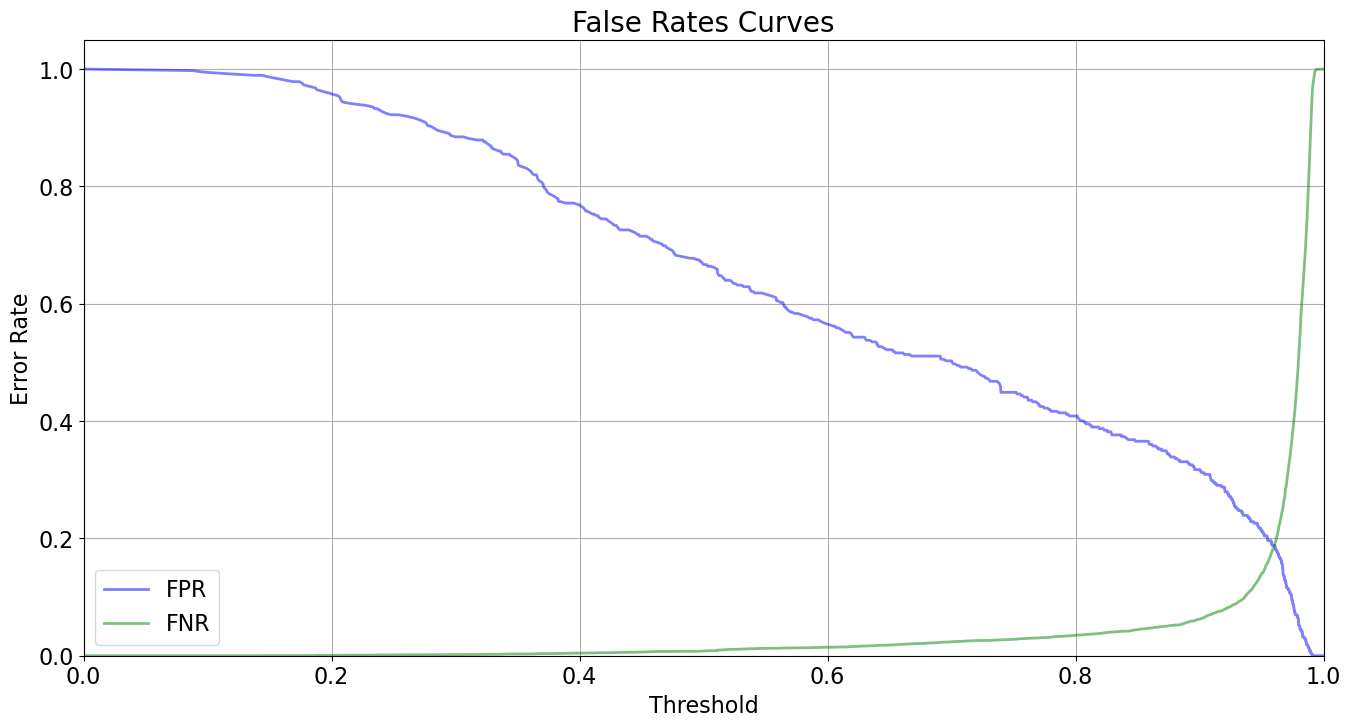

In [ ]:
curve = get_roc_curve(clf, validation_pool)
(fpr, tpr, thresholds) = curve
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)
plt.figure(figsize=(16,8))
style = {"alpha": 0.5, "lw": 2}
plt.plot(thresholds, fpr, color="blue", label="FPR", **style)
plt.plot(thresholds, fnr, color="green", label="FNR", **style)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel("Threshold", fontsize=16)
plt.ylabel("Error Rate", fontsize=16)
plt.title("False Rates Curves", fontsize=20)
plt.legend(loc="lower left", fontsize=16)

In [ ]:
print(select_threshold(clf, validation_pool, FNR=0.01))
print(select_threshold(clf, validation_pool, FPR=0.01))

0.5165367985887064
0.9886729205587221


In [ ]:
metrics = model.eval_metrics(
    data=validation_pool,
    metrics=["Logloss", "AUC"],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)
print("AUC values:\n{}".format(np.array(metrics["AUC"])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

AUC values:
[0.5509 0.676  0.8346 0.845  0.8496 0.8711 0.8742 0.8821 0.8824 0.8849
 0.8848 0.8848 0.8884 0.8895 0.8931 0.8924 0.8946 0.8947 0.8955 0.8953
 0.8949 0.8946 0.8945 0.8944 0.8949 0.895  0.8948 0.8951 0.8951 0.8953
 0.8956 0.8962 0.8963 0.8966 0.8965 0.8953 0.8954 0.8959 0.896  0.8961
 0.8966 0.8971 0.897  0.8974 0.8986 0.8988 0.8994]


In [ ]:
np.array(model.get_feature_importance(prettified=True))

array([['RESOURCE', 22.496743142523687],
       ['MGR_ID', 16.774097733451306],
       ['ROLE_ROLLUP_2', 16.124979919948476],
       ['ROLE_DEPTNAME', 10.674289861075822],
       ['ROLE_FAMILY_DESC', 10.003589857945684],
       ['ROLE_FAMILY', 7.349411280862393],
       ['ROLE_CODE', 6.782752983339941],
       ['ROLE_TITLE', 5.537561552530908],
       ['ROLE_ROLLUP_1', 4.256573668321757]], dtype=object)

In [ ]:
np.array(model.get_feature_importance(train_pool, "LossFunctionChange", prettified=True))

array([['MGR_ID', 0.02571963208981826],
       ['RESOURCE', 0.020559604191565457],
       ['ROLE_FAMILY_DESC', 0.009626636184586333],
       ['ROLE_CODE', 0.009055493226251982],
       ['ROLE_ROLLUP_2', 0.00482102892777757],
       ['ROLE_DEPTNAME', 0.004686314075544487],
       ['ROLE_TITLE', 0.0009410048121068589],
       ['ROLE_ROLLUP_1', -0.00014169897971078962],
       ['ROLE_FAMILY', -0.0004909851274132303]], dtype=object)

In [ ]:
print(model.predict_proba([X.iloc[1,:]]))
print(model.predict_proba([X.iloc[87,:]]))

[[0.0056 0.9944]]
[[0.007 0.993]]


In [ ]:
shap_values = model.get_feature_importance(validation_pool, "ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(6554, 9)


In [ ]:
shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_validation.iloc[1,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


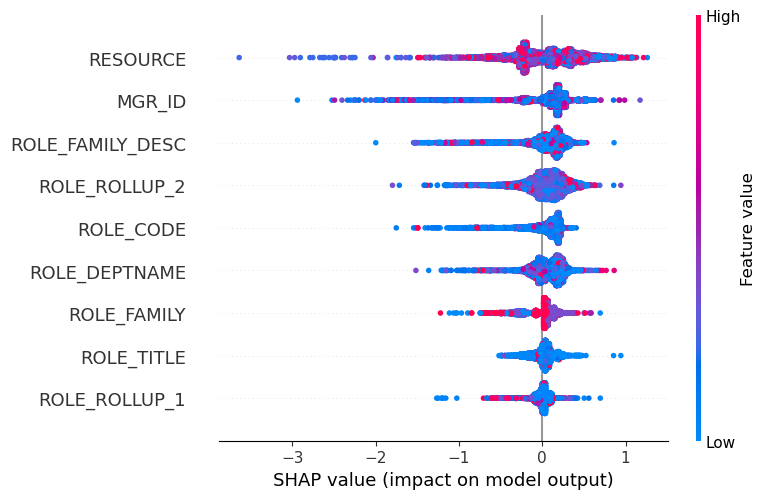

In [ ]:
shap.summary_plot(shap_values, X_validation)

In [ ]:
tuned_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=1
)
tuned_model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
fast_model = CatBoostClassifier(
    boosting_type="Plain",
    rsm=0.5,
    one_hot_max_size=50,
    leaf_estimation_iterations=1,
    max_ctr_complexity=1,
    iterations=100,
    learning_rate=0.05,
    bootstrap_type="Bernoulli",
    subsample=0.5
)
fast_model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
small_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.05,
    model_size_reg=50,
    max_ctr_complexity=1,
    ctr_leaf_count_limit=100
)
small_model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))